# Markov Graph Generation

In [1]:
import firebase_admin
from firebase_admin import credentials, firestore
from markov import get_records_by_email, get_all_records, get_record_by_id, create_nested_tables
import pandas as pd
import networkx as nx

## Instantiate DB

In [ ]:
# Fetch the service account key JSON file contents
cred = credentials.Certificate('../secrets/firebase_service_credentials.json')
firebase_admin.initialize_app(cred)

In [3]:
# Reference Firestore
db = firestore.client()

# Access a collection (e.g., 'userData')
docs = db.collection('userData').stream()

In [4]:
documents = get_records_by_email(db, "gagnonjikael@gmail.com")

/home/jikael/anaconda3/envs/markov/lib/python3.9/site-packages/google/cloud/firestore_v1/base_collection.py:303: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


In [5]:
documents

[{'documents': [{'createdAt': '2025-04-10T14:52:38.665Z',
    'type': 'Interaction',
    'metadata': {'name': 'Video'},
    'url': 'https://www.youtube.com/',
    'sourceState': '/'},
   {'createdAt': '2025-04-10T14:52:38.691Z',
    'type': 'Self-Loop',
    'metadata': {'urlChange': False},
    'url': 'https://www.youtube.com/',
    'sourceState': '/'},
   {'createdAt': '2025-04-10T14:52:38.693Z',
    'type': 'State Change',
    'metadata': {'destinationState': '/watch'},
    'url': 'https://www.youtube.com/watch?v=X08GFEskfRo',
    'sourceState': '/'},
   {'createdAt': '2025-04-10T14:52:44.550Z',
    'type': 'Interaction',
    'metadata': {'name': 'Watch Page Recommended Video'},
    'url': 'https://www.youtube.com/watch?v=X08GFEskfRo',
    'sourceState': '/watch'},
   {'createdAt': '2025-04-10T14:52:44.560Z',
    'type': 'Self-Loop',
    'metadata': {'urlChange': True},
    'url': 'https://www.youtube.com/watch?v=ISB3HtmMXyQ',
    'sourceState': '/watch'},
   {'createdAt': '2025-04-1

In [282]:
documents = get_all_records(db)

In [283]:
documents

[{'documents': [{'createdAt': '2025-04-09T00:30:13.205Z',
    'type': 'Interaction',
    'metadata': {'name': 'Video'},
    'url': 'https://www.youtube.com/',
    'sourceState': '/'},
   {'createdAt': '2025-04-09T00:30:13.216Z',
    'type': 'Self-Loop',
    'metadata': {'urlChange': False},
    'url': 'https://www.youtube.com/',
    'sourceState': '/'},
   {'createdAt': '2025-04-09T00:30:13.218Z',
    'type': 'State Change',
    'metadata': {'destinationState': '/watch'},
    'url': 'https://www.youtube.com/watch?v=kCk3Okd4A8w',
    'sourceState': '/'}],
  'sessionInfo': {'startTime': '2025-04-09T00:30:01.477Z',
   'email': 'jikaelgagnon@gmail.com',
   'endTime': '2025-04-09T00:30:18.511Z',
   'url': 'https://www.youtube.com/'}},
 {'documents': [{'createdAt': '2025-04-09T01:11:34.217Z',
    'type': 'Interaction',
    'metadata': {'name': 'Video'},
    'url': 'https://www.youtube.com/',
    'sourceState': '/'},
   {'createdAt': '2025-04-09T01:11:34.227Z',
    'type': 'Self-Loop',
    'm

## Get the data using helper functions

In [284]:
nested_tables_list = [create_nested_tables(doc) for doc in documents]

This contains nested tables of the following form:

In [285]:
emails = set(df.email[0] for df in nested_tables_list)

In [286]:
get_record_by_id(db, "hJJPFeL5lgUOs2zJ5lOP")

In [287]:
emails

{'jikaelgagnon@gmail.com'}

In [288]:
nested_tables_list[0].documents.iloc[0]

,createdAt,type,metadata,url,sourceState
0,2025-04-09T00:30:13.205Z,Interaction,{'name': 'Video'},https://www.youtube.com/,/
1,2025-04-09T00:30:13.216Z,Self-Loop,{'urlChange': False},https://www.youtube.com/,/
2,2025-04-09T00:30:13.218Z,State Change,{'destinationState': '/watch'},https://www.youtube.com/watch?v=kCk3Okd4A8w,/


In [289]:
doc_tables = [r.documents.iloc[0] for r in nested_tables_list]
start_states = [table.sourceState[0] for table in doc_tables]

In [312]:
start_states

['/', '/', '/', '/', '/watch']

In [290]:
len(doc_tables)

5

In [291]:
merged_docs = pd.concat(doc_tables, ignore_index=True)

In [292]:
duplicate_mask = merged_docs['url'] == merged_docs['url'].shift()

# Keep all rows where the URL is different from the previous row
merged_docs = merged_docs[~duplicate_mask]

In [293]:
G = nx.DiGraph()

In [294]:
merged_docs['createdAt'] = merged_docs['createdAt'].apply(lambda x: pd.to_datetime(x.split('GMT')[0].strip()))

In [295]:
import re

def get_rid_of_at(sourceState):
    match = re.search(r'\/@/*', sourceState)
    if (match):
        return "/@"
    return sourceState    

In [296]:
get_rid_of_at("/@")

'/@'

In [297]:
merged_docs.sourceState = merged_docs.sourceState.map(get_rid_of_at)

In [298]:
states = merged_docs.sourceState.unique()
states

array(['/', '/watch', '/results', '/@', '/shorts', '/feed/subscriptions',
       '/feed/playlists', '/playlist', '/feed/you'], dtype=object)

In [299]:
connections = list(merged_docs[merged_docs.type != 'interaction'].sourceState)
connections

['/',
 '/',
 '/',
 '/',
 '/watch',
 '/watch',
 '/watch',
 '/results',
 '/@',
 '/@',
 '/@',
 '/@',
 '/@',
 '/@',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/',
 '/results',
 '/watch',
 '/watch',
 '/',
 '/',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/feed/subscriptions',
 '/',
 '/watch',
 '/@',
 '/watch',
 '/watch',
 '/watch',
 '/feed/playlists',
 '/playlist',
 '/feed/you',
 '/',
 '/watch',
 '/shorts',
 '/watch',
 '/watch',
 '/watch',
 '/watch',
 '/watch',
 '/shorts',
 '/shorts',
 '/shorts',
 '/shorts',
 '/',
 '/watch',
 '/results']

In [300]:
G.add_nodes_from(states)

In [301]:
G.nodes

NodeView(('/', '/watch', '/results', '/@', '/shorts', '/feed/subscriptions', '/feed/playlists', '/playlist', '/feed/you'))

In [302]:
edges = []
for i in range(1, len(connections)):
    edges.append((connections[i-1], connections[i]))

In [303]:
d = dict()
for state in states:
    d[state] = dict(zip(states, [0 for state in states]))

In [304]:
for edge in edges:
    src, dst = edge
    d[src][dst] += 1

In [305]:
transition_probs = pd.DataFrame(d)
normalized_df = transition_probs.div(transition_probs.sum())
normalized_df.to_dict()['/shorts']

{'/': 0.05263157894736842,
 '/watch': 0.02631578947368421,
 '/results': 0.0,
 '/@': 0.0,
 '/shorts': 0.8947368421052632,
 '/feed/subscriptions': 0.02631578947368421,
 '/feed/playlists': 0.0,
 '/playlist': 0.0,
 '/feed/you': 0.0}

In [306]:
edges

[('/', '/'),
 ('/', '/'),
 ('/', '/'),
 ('/', '/watch'),
 ('/watch', '/watch'),
 ('/watch', '/watch'),
 ('/watch', '/results'),
 ('/results', '/@'),
 ('/@', '/@'),
 ('/@', '/@'),
 ('/@', '/@'),
 ('/@', '/@'),
 ('/@', '/@'),
 ('/@', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/'),
 ('/', '/results'),
 ('/results', '/watch'),
 ('/watch', '/watch'),
 ('/watch', '/'),
 ('/', '/'),
 ('/', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shorts'),
 ('/shorts', '/shor

In [307]:
for src in normalized_df.to_dict():
    for dst, weight in normalized_df.to_dict()[src].items():
        if weight > 0:  # Only add edges with non-zero weights
            G.add_edge(src, dst, weight=weight)

In [308]:
G.edges

OutEdgeView([('/', '/'), ('/', '/watch'), ('/', '/results'), ('/', '/shorts'), ('/watch', '/'), ('/watch', '/watch'), ('/watch', '/results'), ('/watch', '/@'), ('/watch', '/shorts'), ('/watch', '/feed/playlists'), ('/results', '/watch'), ('/results', '/@'), ('/@', '/watch'), ('/@', '/@'), ('/@', '/shorts'), ('/shorts', '/'), ('/shorts', '/watch'), ('/shorts', '/shorts'), ('/shorts', '/feed/subscriptions'), ('/feed/subscriptions', '/'), ('/feed/playlists', '/playlist'), ('/playlist', '/feed/you'), ('/feed/you', '/')])

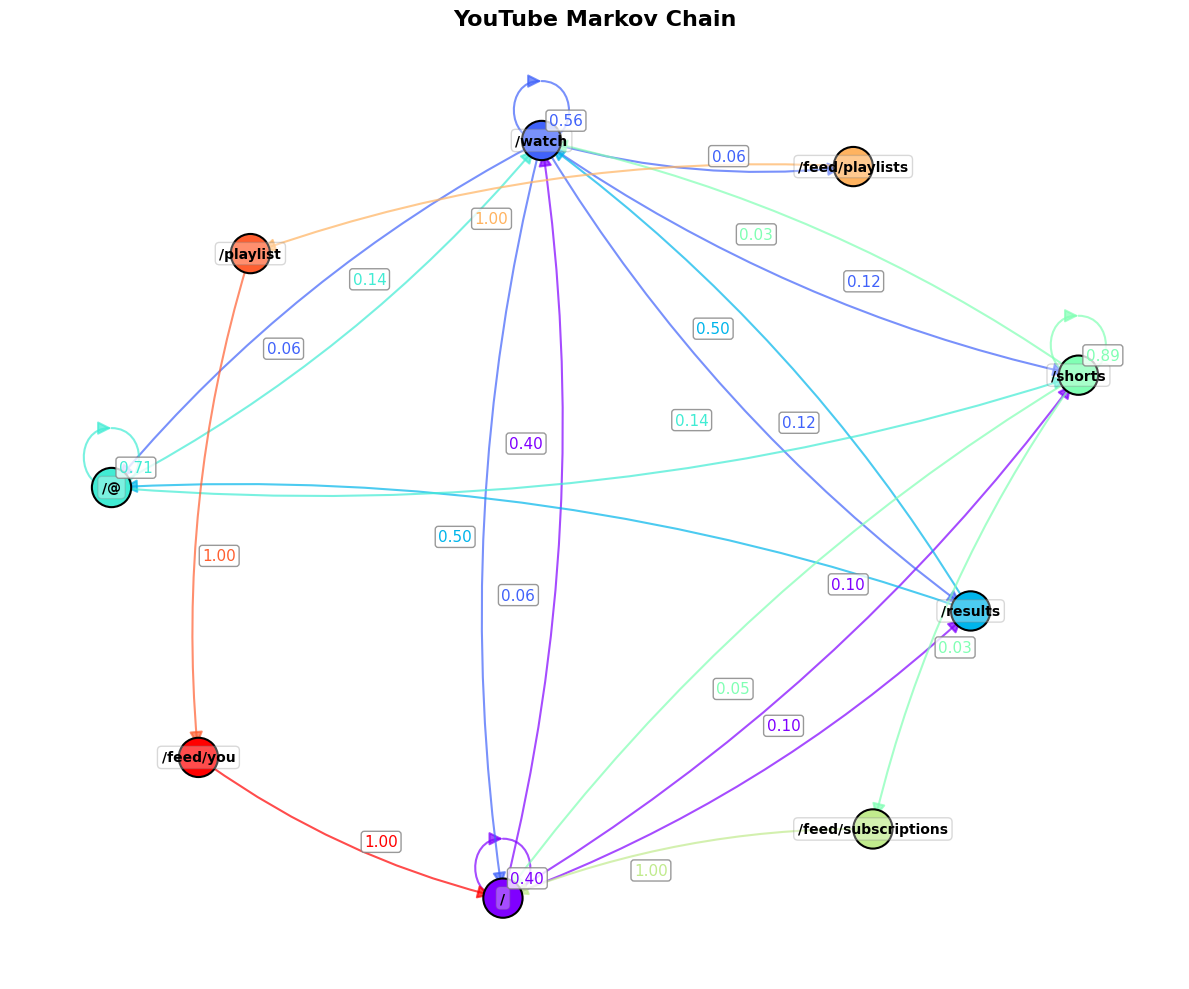

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(12, 10))

pos = nx.spring_layout(G, k=5, seed=11)

num_nodes = len(G.nodes())
colors = cm.rainbow(np.linspace(0, 1, num_nodes))

node2color = {node: color for node, color in zip(G.nodes(), colors)}

nx.draw_networkx_nodes(
    G,
    pos,
    node_size=800,
    nodelist=list(G.nodes()),
    node_color=[node2color[node] for node in G.nodes()],
    edgecolors='black',
    linewidths=1.5
)

for edge in G.edges():
    src, dst = edge
    edge_color = node2color[src]
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=[edge],
        width=1.5,
        edge_color=[edge_color],
        alpha=0.7,
        arrowsize=20,
        connectionstyle='arc3,rad=0.1'
    )

label_options = {
    "bbox": {"boxstyle": "round,pad=0.3", "facecolor": "white", "alpha": 0.3, "edgecolor": "gray"},
    "font_size": 10,
    "font_weight": "bold"
}
nx.draw_networkx_labels(G, pos, font_color='black', **label_options)

raw_edge_weights = nx.get_edge_attributes(G, 'weight')
self_loops = {e: f"{w:.2f}" for e, w in raw_edge_weights.items() if e[0] == e[1]}
other_edges = {e: f"{w:.2f}" for e, w in raw_edge_weights.items() if e[0] != e[1]}

label_fontsize = 11
label_bbox = dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='gray', alpha=0.8)

label_pos = 0.6

for (src, dst), label in other_edges.items():
    x = (1 - label_pos) * pos[src][0] + label_pos * pos[dst][0]
    y = (1 - label_pos) * pos[src][1] + label_pos * pos[dst][1]
    plt.text(
        x, y,
        label,
        fontsize=label_fontsize,
        color=node2color[src],
        bbox=label_bbox,
        horizontalalignment='center',
        verticalalignment='center'
    )

for (node, _), label in self_loops.items():
    x, y = pos[node]
    plt.text(
        x + 0.05, y + 0.05,
        label,
        fontsize=label_fontsize,
        color=node2color[node],
        bbox=label_bbox,
        horizontalalignment='center',
        verticalalignment='center'
    )

plt.axis('off')

plt.title('YouTube Markov Chain', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()
